<a href="https://colab.research.google.com/github/maybe-surf/MAP-3305-Engineering-math/blob/main/Copy_of_Complex_Systems_Lab_Pretrained_Folder_Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rapid economic growth has its downsides which includes increase in all sorts of pollution. Ocean pollution is one such problems caused by growing industry, which can be detrimental for environment. The dangers of ocean pollution can include depletion of oxygen in seawater, harm to marine animals, and it even threatens human health when we consume sea products that are contaminated. 

In fighting ocean pollution, a lot can be done through preventive measures, however, there is a need for new solutions to deal with the trash that has already made its way into the ocean such as the Great Pacific Garbage Patch. Cleaning up such large areas of contaminations requires a significant amount of work in engineering the appropriate equipment, funding the cleaning, and devising policies to manage it. However, it all starts with detecting the garbage patches in the ocean.

For this reason, in my final project I decided to work on a software that could successfully distinguish clean and polluted areas of the ocean. Thus, given an image of ocean surface, the program can determine whether it is polluted or not. Since the input data is visual, it was decided to use convolution neural networks (CNN) architecture AlexNet in order to analyze the data and build a model for distinguishing polluted and unpolluted regions from the images. At the core of CNN lies the mathematical concept which, given two functions, produces a third function that shows how the shape of one function is modified by the other. The model was trained using a set of roughly 100 images classified as either polluted or clean. The model was then tested and showed over 90% accuracy. 

Using this model will greatly facilitate fighting ocean pollution. Thus, input data in the form of images can be collected using drones or other technology. Each image can be linked to its geographical location. Each image then can be tested using the described CNN and if it is classified as polluted, cleaning vessels can be sent to that location. 


In [ ]:
!pip install flashtorch
!pip install barbar

  Created wheel for flashtorch: filename=flashtorch-0.1.3-py3-none-any.whl size=26245 sha256=2379099889d8926cbd51cb490dfc0e416c5c9858c5e45bdbb809dfac33abf237
  Stored in directory: /root/.cache/pip/wheels/e8/bc/36/9ac3236719be1f1c6d1d758fc5e404410fe17027dd80d1d06d
Successfully built flashtorch


In [ ]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools
from sklearn.metrics import confusion_matrix
from torchsummary import summary

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-gpdnmw5j
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-gpdnmw5j
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-py3-none-any.whl size=7429 sha256=9035ec2ab21e826b740688db95336d5650ae78b0d58287228238049a419507c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-x4k61hzz/wheels/81/51/4e/93fa1b6f290ba71f589593454d4d769f9baebd8c4c376822d9
Successfully built ImportMPCR
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create new folder on your google drive like below:

In [ ]:
data_dir = '/content/drive/My Drive/DS1/'

In [ ]:
os.chdir(data_dir)

In [ ]:
pwd

'/content/drive/My Drive/DS1'

In [ ]:
ls

train/  valid/


In [ ]:
ls train

clean/  polluted/


In [ ]:
ls valid

clean/  polluted/


In [ ]:
dataset_labels =["clean", "polluted"] #<--- Replace with your labels 

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #Data Augmentation 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
batch_size = 16
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_sizes

{'train': 87, 'valid': 20}

In [ ]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

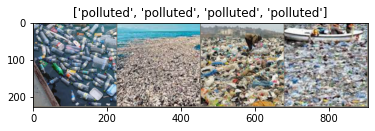

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
classes = classes[:4] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[x] for x in classes])

In [ ]:
def train_model(model, num_epochs=25):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() 
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        
        scheduler.step()
    
        ###Val
        model.eval()  
        running_corrects = 0
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [ ]:
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
batch_size = 16
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model.classifier[6] = nn.Linear(4096, 102)

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model = train_model(model, num_epochs=3)

Epoch:  1 / 3
Train  Acc: 0.78
Valid  Acc: 0.85
#######################
Epoch:  2 / 3
Train  Acc: 0.85
Valid  Acc: 0.90
#######################
Epoch:  3 / 3
Train  Acc: 0.92
Valid  Acc: 1.00
#######################


In [ ]:
model = train_model(model, num_epochs=30)

Epoch:  1 / 30
Train  Acc: 0.95
Valid  Acc: 0.90
#######################
Epoch:  2 / 30
Train  Acc: 0.94
Valid  Acc: 1.00
#######################
Epoch:  3 / 30
Train  Acc: 0.98
Valid  Acc: 0.90
#######################
Epoch:  4 / 30
Train  Acc: 0.95
Valid  Acc: 0.90
#######################
Epoch:  5 / 30
Train  Acc: 0.98
Valid  Acc: 0.90
#######################
Epoch:  6 / 30
Train  Acc: 0.95
Valid  Acc: 1.00
#######################
Epoch:  7 / 30
Train  Acc: 0.98
Valid  Acc: 1.00
#######################
Epoch:  8 / 30
Train  Acc: 0.98
Valid  Acc: 1.00
#######################
Epoch:  9 / 30
Train  Acc: 0.97
Valid  Acc: 1.00
#######################
Epoch:  10 / 30
Train  Acc: 0.99
Valid  Acc: 1.00
#######################
Epoch:  11 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  12 / 30
Train  Acc: 1.00
Valid  Acc: 1.00
#######################
Epoch:  13 / 30
Train  Acc: 0.98
Valid  Acc: 1.00
#######################
Epoch:  14 / 30
Train  Acc: 1.00
Valid  Acc: 1.

In [ ]:
def visualize_model(model, num_images=16):
    model.eval()
    index = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[preds[j]] + '     class: ' + dataset_labels[labels[j]]
            imshow(inputs.cpu().data[j],title1)

            if index == num_images:
                return

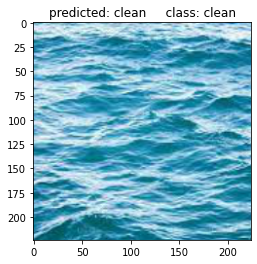

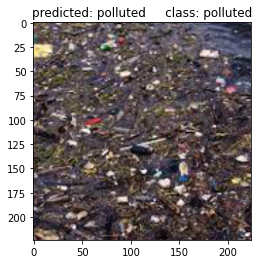

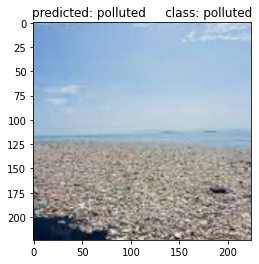

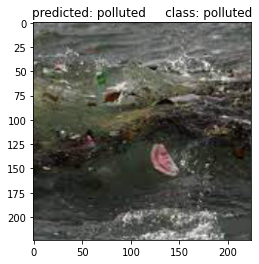

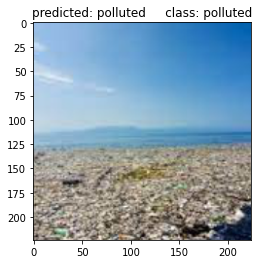

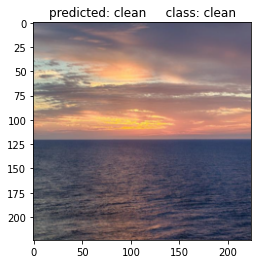

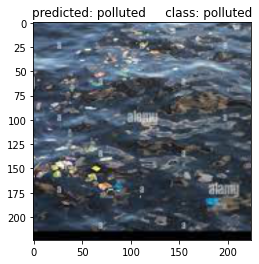

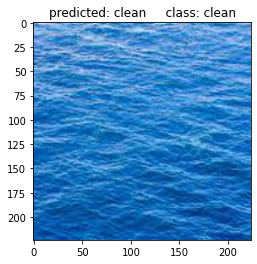

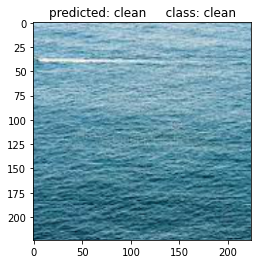

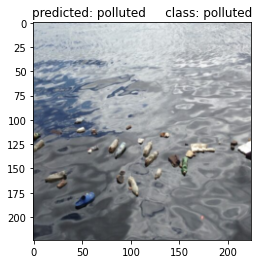

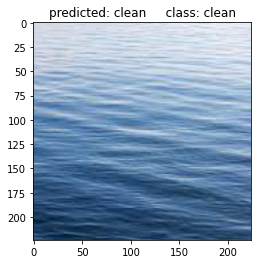

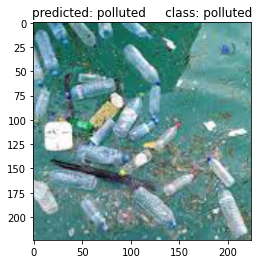

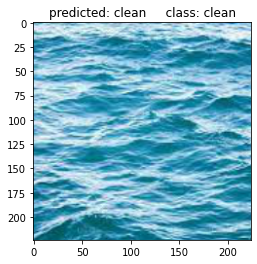

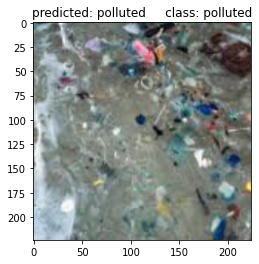

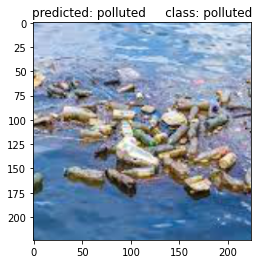

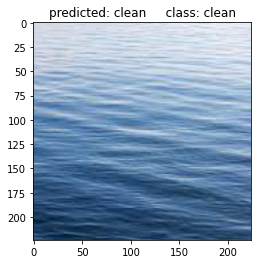

In [ ]:
visualize_model(model)

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

# Test

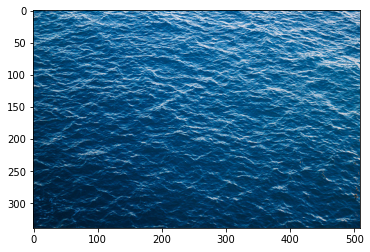

In [ ]:
image = io.imread('https://media.istockphoto.com/photos/blue-sea-water-background-atlantic-picture-id1136870172?b=1&k=20&m=1136870172&s=170667a&w=0&h=2_0iFR7J16gfksWR8blEMiSHX3gSaX-T1mCFIPJmtrk=')
plt.imshow(image);

In [ ]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [ ]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]

In [ ]:
print('predicted: ' + dataset_labels[preds])

predicted: clean


In [ ]:
batch_size = 1024 #large batch size so we test all the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
inputs,labels = next(iter(dataloaders['valid']))
inputs = inputs.to(device)
labels = labels.detach().cpu().numpy()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
outputs = model(inputs)
preds = torch.max(outputs, 1)[1].detach().cpu().numpy()

In [ ]:
cm = confusion_matrix(preds.reshape(-1),labels)

In [ ]:
print("Confusion Matrix : ")
cm

Confusion Matrix : 


array([[10,  0],
       [ 0, 10]])